
IMPORTS:

In [1]:
import pickle
import os
from os import path

import matplotlib.pyplot as plt

import numpy as np

import sys
import torch

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import cv2
import csv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.models import Model
from PIL import Image
import string
from keras.callbacks import ModelCheckpoint

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Using TensorFlow backend.


Download data from drive to speed things up

In [0]:
zip_path = '/content/drive/My Drive/KNN/2017-IWT4S-CarsReId_LP-dataset.zip'
!cp "{zip_path}" .
!unzip -q '2017-IWT4S-CarsReId_LP-dataset.zip'

Parse csv and load train/test data

In [3]:
train_images = []
train_labels = []
test_images  = []
test_labels  = []

with open('trainVal.csv', 'r') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            # Skip header row
            line_count += 1
        else:
            if int(row[3]) == 0:
                if(len(row[2]) != 7):
                    continue
                img = cv2.imread(row[1])
                if img is None:
                    continue
                img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
                res = cv2.resize(img, dsize=(200, 40), interpolation=cv2.INTER_CUBIC)
                normalizedImg = np.zeros((200, 40))
                normalizedImg = cv2.normalize(res,  normalizedImg, 0, 255, cv2.NORM_MINMAX)
                test_labels.append([row[2]])
                test_images.append(normalizedImg)
            else:
                if(len(row[2]) != 7):
                    continue
                img = cv2.imread(row[1])
                if img is None:
                    continue
                img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
                res = cv2.resize(img, dsize=(200, 40), interpolation=cv2.INTER_CUBIC)
                normalizedImg = np.zeros((200, 40))
                normalizedImg = cv2.normalize(res,  normalizedImg, 0, 255, cv2.NORM_MINMAX)
                train_labels.append([row[2]])
                train_images.append(normalizedImg)

train_images = np.asarray(train_images)
train_labels = np.asarray(train_labels)

img_train_part = train_images[:int(len(train_images) * .8)]
labels_train_part = train_labels[:int(len(train_labels) * .8)]
img_val_part = train_images[int(len(train_images) * .8):]
labels_val_part = train_labels[int(len(train_labels) * .8):]

# Debug
print(train_images.shape)
print(train_labels.shape)
print('')
print(img_train_part.shape)
print(labels_train_part.shape)
print('')
print(img_val_part.shape)
print(labels_val_part.shape)

(105410, 40, 200, 3)
(105410, 1)

(84328, 40, 200, 3)
(84328, 1)

(21082, 40, 200, 3)
(21082, 1)


Convert to 'loss function friendly' format

In [4]:
# Create dict to encode digits to numbers
y_map = {}
for i,d in enumerate(string.digits+string.ascii_uppercase + '#'):
    y_map[d] = i

# Utility function for split string in char and encode them
def split_encode(x):
    x = list(x[0])
    x = [y_map[d] for d in x]
    return x

# Transform target
train_labels = np.apply_along_axis(split_encode, 1, labels_train_part)
val_labels = np.apply_along_axis(split_encode, 1, labels_val_part)

# Debug
print(img_train_part.shape)
print(train_labels.shape)
print(img_val_part.shape)
print(val_labels.shape)

(84328, 40, 200, 3)
(84328, 7)
(21082, 40, 200, 3)
(21082, 7)


Class names A-Z, 0-9

In [5]:
chars  = [chr(i) for i in list(range(ord('A'),ord('Z')+1))]
digits = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

class_names = digits + chars

print(class_names)
print(len(class_names))

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
36


Check few images

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


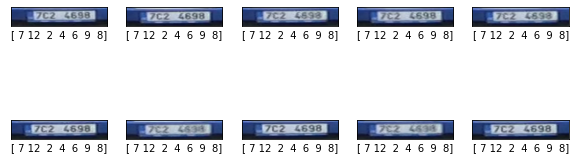

In [14]:
plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(train_labels[i])
plt.show()

Create model

In [16]:
# 32,64,128 - filters count
# (x, x) is size of convolutional kernel
# relu is activation function
# batch normalization after each convolutional layer

from keras.layers import *

inp_dim = (40, 200, 3)
x_inp = Input(shape=inp_dim)

# First part
x = Conv2D(32, (3, 3), padding='same', use_bias=True, bias_initializer='zeros', bias_regularizer=None, bias_constraint=None)(x_inp)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Conv2D(32, (3, 3), padding='same', use_bias=True, bias_initializer='zeros', bias_regularizer=None, bias_constraint=None)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Conv2D(32, (3, 3), padding='same', use_bias=True, bias_initializer='zeros', bias_regularizer=None, bias_constraint=None)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = MaxPooling2D((2, 2))(x)

# Second part
x = Conv2D(64, (3, 3), padding='same', use_bias=True, bias_initializer='zeros', bias_regularizer=None, bias_constraint=None)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Conv2D(64, (3, 3), padding='same', use_bias=True, bias_initializer='zeros', bias_regularizer=None, bias_constraint=None)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Conv2D(64, (3, 3), padding='same', use_bias=True, bias_initializer='zeros', bias_regularizer=None, bias_constraint=None)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = MaxPooling2D((2, 2))(x)

# Third part
x = Conv2D(128, (3, 3), padding='same', use_bias=True, bias_initializer='zeros', bias_regularizer=None, bias_constraint=None)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Conv2D(128, (3, 3), padding='same', use_bias=True, bias_initializer='zeros', bias_regularizer=None, bias_constraint=None)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Conv2D(128, (3, 3), padding='same', use_bias=True, bias_initializer='zeros', bias_regularizer=None, bias_constraint=None)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = MaxPooling2D((2, 2))(x)


x_out = Flatten()(x)
model = Model(x_inp, x_out)

branches = []

for _ in range(7):
    x = Dense(128)(x_out)
    x = Dense(36)(x)
    x = Activation("softmax")(x)
    branches.append(x)

final_model = Model(inputs = x_inp, outputs = branches)

# Display model architecture
final_model.summary()

model_json = final_model.to_json()
with open("/content/drive/My Drive/KNN/bias_model.json", "w") as json_file:
    json_file.write(model_json)

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 40, 200, 3)   0                                            
__________________________________________________________________________________________________
conv2d_46 (Conv2D)              (None, 40, 200, 32)  896         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_46 (BatchNo (None, 40, 200, 32)  128         conv2d_46[0][0]                  
__________________________________________________________________________________________________
activation_81 (Activation)      (None, 40, 200, 32)  0           batch_normalization_46[0][0]     
___________________________________________________________________________________________

Compile and train the model

In [0]:
# Checkpoint callback (to save weights after each epoch)
filepath = "/content/drive/My Drive/KNN/model-bias-{epoch:02d}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=False, save_weights_only=True, mode='auto', period=1)

# Adam optimizer with 0.001 learning rate
final_model.compile(tf.keras.optimizers.Adam(learning_rate=0.001),
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                    metrics=['accuracy'])

# Train for 80 epochs
history = final_model.fit(img_train_part, [train_labels[:,i] for i in range(7)], epochs=80,
                          validation_data=(img_val_part, [val_labels[:,i] for i in range(7)]), callbacks=[checkpoint])

Train on 84328 samples, validate on 21082 samples
Epoch 1/80
84328/84328 [==============================] - 155s 2ms/step - loss: 6.2759 - activation_90_loss: 0.8430 - activation_91_loss: 0.6015 - activation_92_loss: 1.1821 - activation_93_loss: 0.8718 - activation_94_loss: 0.8721 - activation_95_loss: 0.9475 - activation_96_loss: 0.9561 - activation_90_accuracy: 3.7947e-04 - activation_91_accuracy: 0.0037 - activation_92_accuracy: 0.0742 - activation_93_accuracy: 0.0882 - activation_94_accuracy: 0.1083 - activation_95_accuracy: 0.1465 - activation_96_accuracy: 0.1443 - val_loss: 3.9072 - val_activation_90_loss: 0.4669 - val_activation_91_loss: 0.5781 - val_activation_92_loss: 0.8681 - val_activation_93_loss: 0.3423 - val_activation_94_loss: 0.5760 - val_activation_95_loss: 0.5331 - val_activation_96_loss: 0.5428 - val_activation_90_accuracy: 4.7434e-05 - val_activation_91_accuracy: 0.0030 - val_activation_92_accuracy: 0.0562 - val_activation_93_accuracy: 0.0896 - val_activation_94_acc

Evaluate the model

In [0]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print(test_acc)